In [1]:

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from kitetrader import Kite
import pyotp
import pandas as pd
import pandas_ta as ta
import datetime as dt
from datetime import datetime,timedelta
import numpy as np
from io import BytesIO

[*********************100%%**********************]  1 of 1 completed
C:\Users\Kishan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0460 - val_loss: 0.0431
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0074 - val_loss: 0.0021
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0036 - val_loss: 9.8278e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026 - val_loss: 5.0798e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0020 - val_loss: 6.2609e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0023 - val_loss: 5.2025e-04
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0020 - val_loss: 9.6536e-04
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0018 - val_loss: 5.1274e-04
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 

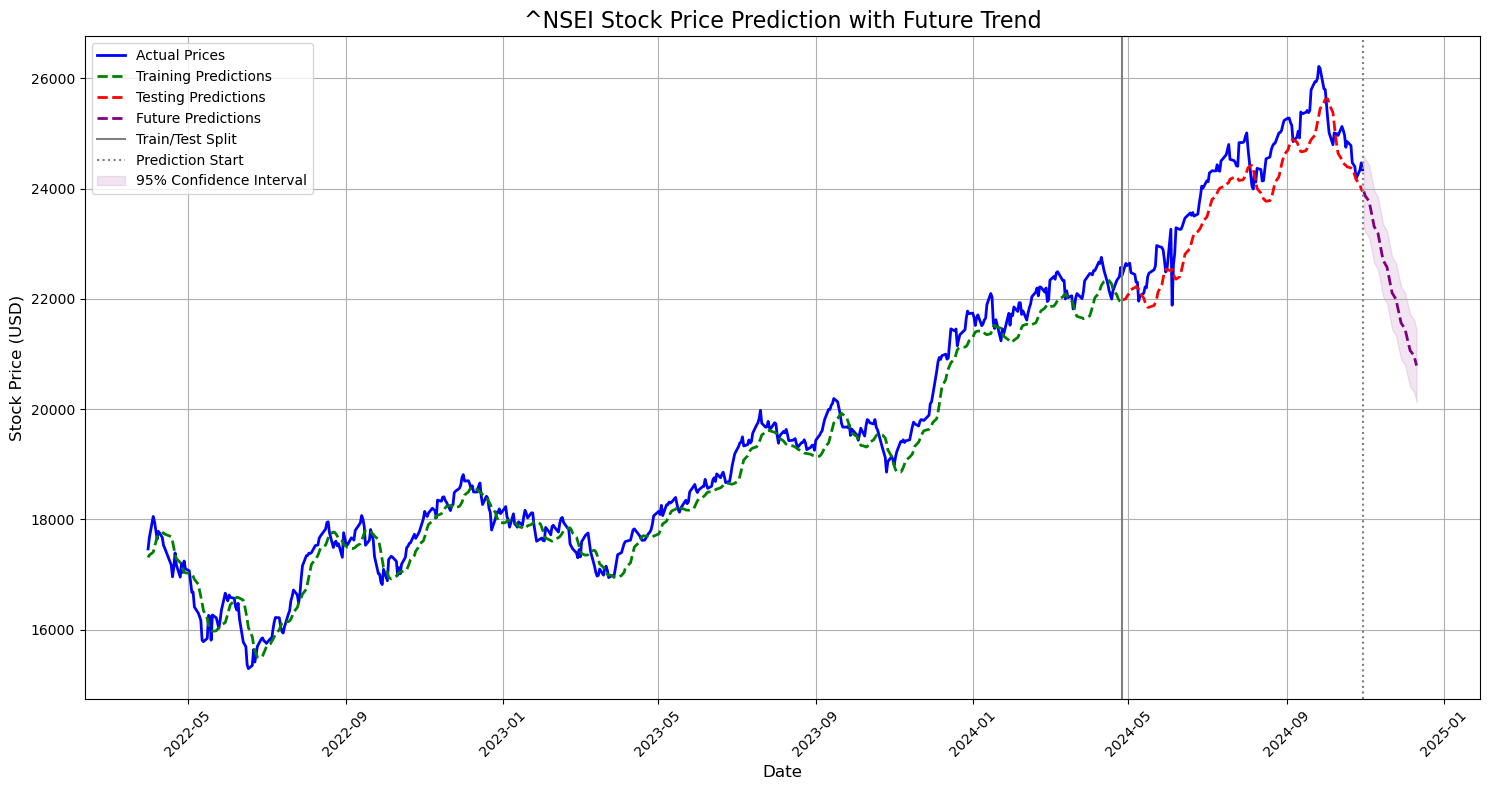


Future Price Predictions:
2024-10-31: $23948.43
2024-11-01: $23870.61
2024-11-04: $23774.64
2024-11-05: $23667.31
2024-11-06: $23552.88
2024-11-07: $23434.12
2024-11-08: $23312.79
2024-11-11: $23190.07
2024-11-12: $23066.78
2024-11-13: $22943.48
2024-11-14: $22820.61
2024-11-15: $22698.50
2024-11-18: $22577.43
2024-11-19: $22457.62
2024-11-20: $22339.24
2024-11-21: $22222.47
2024-11-22: $22107.42
2024-11-25: $21994.19
2024-11-26: $21882.85
2024-11-27: $21773.48
2024-11-28: $21666.10
2024-11-29: $21560.74
2024-12-02: $21457.41
2024-12-03: $21356.12
2024-12-04: $21256.86
2024-12-05: $21159.59
2024-12-06: $21064.31
2024-12-09: $20970.98
2024-12-10: $20879.56
2024-12-11: $20790.02


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch stock data from Yahoo Finance
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data['Close'].values.reshape(-1, 1), stock_data.index

def prepare_data(data, time_steps):
    """
    Prepare data for LSTM model
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:i+time_steps])
        y.append(scaled_data[i+time_steps])
    
    return np.array(X), np.array(y), scaler

def create_model(time_steps):
    """
    Create and compile LSTM model
    """
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def generate_future_dates(last_date, num_days):
    """
    Generate future dates for predictions
    """
    future_dates = []
    current_date = last_date
    for _ in range(num_days):
        current_date += timedelta(days=1)
        # Skip weekends
        while current_date.weekday() > 4:
            current_date += timedelta(days=1)
        future_dates.append(current_date)
    return pd.DatetimeIndex(future_dates)

def predict_future(model, last_sequence, scaler, n_future):
    """
    Predict future values
    """
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_future):
        # Get prediction for next day
        current_prediction = model.predict(current_sequence.reshape(1, *current_sequence.shape))
        future_predictions.append(current_prediction[0])
        
        # Update sequence for next prediction
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = current_prediction
    
    future_predictions = np.array(future_predictions)
    future_predictions = scaler.inverse_transform(future_predictions)
    
    return future_predictions

def plot_predictions_with_future(dates, actual_values, train_predictions, test_predictions, 
                               future_dates, future_predictions, train_size, time_steps, ticker):
    """
    Plot the actual vs predicted values including future predictions
    """
    plt.figure(figsize=(15, 8))
    
    # Adjust dates array to match the actual values length
    plot_dates = dates[time_steps:]
    
    # Plot actual values
    plt.plot(plot_dates, actual_values.flatten(), 
             label='Actual Prices', color='blue', linewidth=2)
    
    # Plot training predictions
    train_dates = plot_dates[:train_size]
    plt.plot(train_dates, train_predictions.flatten(), 
             label='Training Predictions', color='green', linestyle='--', linewidth=2)
    
    # Plot testing predictions
    test_dates = plot_dates[train_size:]
    plt.plot(test_dates, test_predictions.flatten(), 
             label='Testing Predictions', color='red', linestyle='--', linewidth=2)
    
    # Plot future predictions
    plt.plot(future_dates, future_predictions.flatten(), 
             label='Future Predictions', color='purple', linestyle='--', linewidth=2)
    
    # Add vertical lines to separate periods
    plt.axvline(x=plot_dates[train_size], color='gray', linestyle='-', 
                label='Train/Test Split')
    plt.axvline(x=plot_dates[-1], color='gray', linestyle=':', 
                label='Prediction Start')
    
    # Add confidence interval for future predictions
    future_std = np.std(test_predictions - actual_values[train_size:])
    plt.fill_between(future_dates,
                    (future_predictions - future_std * 2).flatten(),
                    (future_predictions + future_std * 2).flatten(),
                    color='purple', alpha=0.1, label='95% Confidence Interval')
    
    # Customize the plot
    plt.title(f'{ticker} Stock Price Prediction with Future Trend', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price (USD)', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def predict_stock_prices(ticker, start_date, end_date, time_steps=60, train_split=0.8, future_days=30):
    """
    Main function to predict stock prices including future trends
    """
    # Fetch data
    data, dates = fetch_stock_data(ticker, start_date, end_date)
    
    # Prepare data
    X, y, scaler = prepare_data(data, time_steps)
    
    # Split into training and testing sets
    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Create and train model
    model = create_model(time_steps)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                       validation_split=0.1, verbose=1)
    
    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # Predict future values
    last_sequence = X[-1]
    future_predictions = predict_future(model, last_sequence, scaler, future_days)
    
    # Generate future dates
    future_dates = generate_future_dates(dates[-1], future_days)
    
    # Inverse transform predictions
    train_predictions = scaler.inverse_transform(train_predictions)
    test_predictions = scaler.inverse_transform(test_predictions)
    actual_values = scaler.inverse_transform(y)
    
    # Plot results
    plot_predictions_with_future(dates, actual_values, train_predictions, test_predictions,
                               future_dates, future_predictions, train_size, time_steps, ticker)
    
    return {
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'future_predictions': future_predictions,
        'actual_values': actual_values,
        'dates': dates[time_steps:],
        'future_dates': future_dates
    }

if __name__ == "__main__":
    # Set parameters
    ticker = "^NSEI"
    start_date = "2022-01-01"
    end_date = "2024-10-31"
    time_steps = 60  # Number of time steps to look back
    future_days = 30  # Number of days to predict into the future
    
    # Get predictions and plots
    results = predict_stock_prices(ticker, start_date, end_date, time_steps, 
                                 future_days=future_days)
    
    # Print future predictions
    print("\nFuture Price Predictions:")
    for date, price in zip(results['future_dates'], results['future_predictions']):
        print(f"{date.strftime('%Y-%m-%d')}: ${price[0]:.2f}")

In [3]:
with open('C:/Users/Kishan/Desktop/ACTUAL PYTHON WORK/credentials.txt', 'r') as f:
    data = f.read()
    
lines = data.splitlines() 
user_id =  lines[0] 
password = lines[1]
twofa = pyotp.TOTP(lines[2]).now()

kite = Kite(
    user_id,
   password,
   twofa
)

INFO: Auth headers updated with enctoken
INFO: Web Login Success


In [4]:
kite = Kite(enctoken=kite.enctoken)

INFO: Auth headers updated with enctoken


In [5]:
data = kite.instruments()

# Decode the byte string to a regular string
decoded_data = data.decode('utf-8')

# Use BytesIO to convert the string data into a byte stream
csv_data = BytesIO(decoded_data.encode('utf-8'))

# Read the CSV data into a DataFrame
df = pd.read_csv(csv_data)

# Save DataFrame to a CSV file
df.to_csv('instruments.csv', index=False)

# Read the CSV file back into a DataFrame to ensure it was saved correctly
df = pd.read_csv('instruments.csv')

# Display the DataFrame
nse_data = df[df['exchange'] == 'NSE']

In [6]:
nse_data

,instrument_token,exchange_token,tradingsymbol,name,last_price,expiry,strike,tick_size,lot_size,instrument_type,segment,exchange
32652,256265,1001,NIFTY 50,NIFTY 50,0,NaN,0.0,0.00,0,EQ,INDICES,NSE
32654,256777,1003,NIFTY MIDCAP 100,NIFTY MIDCAP 100,0,NaN,0.0,0.00,0,EQ,INDICES,NSE
32656,260105,1016,NIFTY BANK,NIFTY BANK,0,NaN,0.0,0.00,0,EQ,INDICES,NSE
32658,260617,1018,NIFTY 100,NIFTY 100,0,NaN,0.0,0.00,0,EQ,INDICES,NSE
32659,257033,1004,NIFTY DIV OPPS 50,NIFTY DIV OPPS 50,0,NaN,0.0,0.00,0,EQ,INDICES,NSE
...,...,...,...,...,...,...,...,...,...,...,...,...
85831,8150273,31837,SREEL,SREELEATHERS,0,NaN,0.0,0.05,1,EQ,NSE,NSE
85832,8183297,31966,863NHB29-N2,NaN,0,NaN,0.0,0.01,1,EQ,NSE,NSE
85833,8183553,31967,863NHB34-N3,NaN,0,NaN,0.0,0.01,1,EQ,NSE,NSE
85834,8184065,31969,888NHB29-N5,NaN,0,NaN,0.0,0.01,1,EQ,NSE,NSE


In [7]:
def instrument_token(data, symbol):
    """
    This function will return the token number of the instrument from data
    """
    return data[data.tradingsymbol == symbol].instrument_token.values[0]

# def historical_data(symbol, from_date, to_date, interval):
#     """
#     This function will return historical data of the instrument for specific period of days for specific interval
#     """
    
#     df = pd.DataFrame()   
#     int_token = instrument_token(nse_data, symbol)  #the function we defined above which will return token no. of instrument
    
#     to_date   = pd.Timestamp(to_date)
#     from_date = pd.Timestamp(from_date)

#     while True:
#         if from_date >= (to_date - dt.timedelta(60)):                     #if from_date is within the 60 days limit
#             df = pd.concat([df, pd.DataFrame(kite.historical_data(int_token, from_date, to_date, interval))])
#             break
            
#         else:                                                            #if from_date has more than 60 days limit
#             to_date_new = from_date + dt.timedelta(60)
            
#             df = pd.concat([df, pd.DataFrame(kite.historical_data(int_token, from_date, to_date_new, interval))])
            
#             #to_date = from_date.date() + dt.timedelta(60)
#             from_date = to_date_new
            
#     return df



In [8]:
def historical_data(symbol, from_date, to_date, interval):
    """
    This function returns historical data of the instrument for a specific period of days for a specific interval.
    """
    
    df_list = []
    int_token = instrument_token(nse_data, symbol)  # Assuming this is defined elsewhere
    
    to_date = pd.Timestamp(to_date)
    from_date = pd.Timestamp(from_date)

    while from_date <= to_date:
        to_date_new = min(from_date + dt.timedelta(days=60), to_date)
        historical_data = kite.historical_data(int_token, from_date.strftime('%Y-%m-%d'), to_date_new.strftime('%Y-%m-%d'), interval)
        
        # Extract candles data
        if historical_data['status'] == 'success':
            candles = historical_data['data']['candles']
            # Define the columns names as per the structure of candles data
            columns = ['date', 'open', 'high', 'low', 'close', 'volume']
            # Convert to DataFrame
            df = pd.DataFrame(candles, columns=columns)
            
            if not df.empty:
                df_list.append(df)
        
        from_date = to_date_new + dt.timedelta(minutes=1)  # Increment by 1 minute to avoid duplicate data
    
    # Concatenate all DataFrames in the list
    if df_list:
        result_df = pd.concat(df_list, ignore_index=True)
    else:
        result_df = pd.DataFrame(columns=columns)
    
    return result_df

Epoch 1/50


C:\Users\Kishan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0343 - val_loss: 0.0283
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0017 - val_loss: 5.5270e-04
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0015 - val_loss: 5.3945e-04
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0015 - val_loss: 2.9792e-04
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0014 - val_loss: 2.6899e-04
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0015 - val_loss: 4.9275e-04
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step -

C:\Users\Kishan\AppData\Local\Temp\ipykernel_8208\1337779887.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1, 0] = current_prediction  # Replace 'Close' with prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

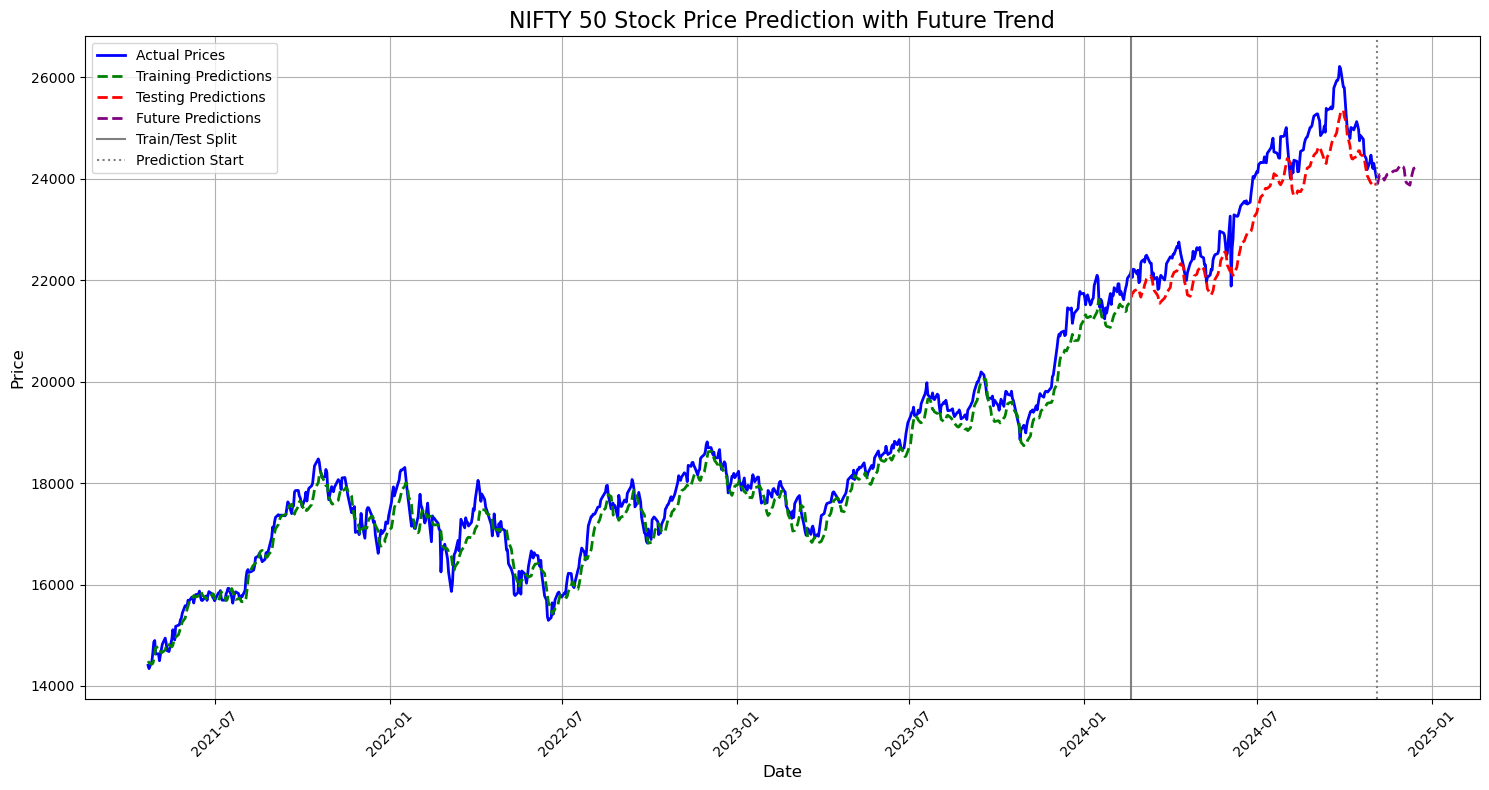


Performance Metrics:
Root Mean Squared Error: 577.33
Mean Absolute Error: 521.97

Future Price Predictions:
2024-11-05: 23889.70
2024-11-06: 24001.21
2024-11-07: 24082.45
2024-11-08: 24072.12
2024-11-11: 24029.15
2024-11-12: 23973.69
2024-11-13: 24013.27
2024-11-14: 24049.24
2024-11-15: 24087.83
2024-11-18: 24114.76
2024-11-19: 24125.58
2024-11-20: 24119.90
2024-11-21: 24142.24
2024-11-22: 24154.90
2024-11-25: 24163.59
2024-11-26: 24184.84
2024-11-27: 24215.11
2024-11-28: 24244.81
2024-11-29: 24265.71
2024-12-02: 24238.18
2024-12-03: 24187.03
2024-12-04: 24028.02
2024-12-05: 23931.26
2024-12-06: 23911.46
2024-12-09: 23874.86
2024-12-10: 23975.29
2024-12-11: 24065.65
2024-12-12: 24142.43
2024-12-13: 24205.88
2024-12-16: 24233.10


In [12]:
import numpy as np
import pandas as pd
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import timedelta

symbol = "NIFTY 50"

def prepare_stock_data_with_indicators(data_True):
    """
    Prepare stock data with SMA and RSI indicators from custom data source
    """
    # Convert date to datetime and ensure it's a DatetimeIndex
    data_True['Date'] = pd.to_datetime(data_True['Date'])
    data_True.set_index('Date', inplace=True)
    
    # Calculate indicators: SMA and RSI
    data_True['SMA'] = data_True['Close'].rolling(window=14).mean()
    data_True['RSI'] = ta.rsi(data_True['Close'], length=14)
    
    # Drop NaN values created by indicator calculation
    data_True.dropna(inplace=True)
    
    # Extract the columns to be used in training
    closing_data = data_True[['Close', 'SMA', 'RSI']].values
    
    return closing_data, data_True.index

def prepare_data_with_indicators(data, time_steps):
    """
    Prepare data with indicators for LSTM model
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:i+time_steps])
        y.append(scaled_data[i+time_steps, 0])  # Predicting the 'Close' price
    
    return np.array(X), np.array(y), scaler

def create_model(time_steps, features):
    """
    Create and compile LSTM model
    """
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(time_steps, features)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def generate_future_dates(last_date, num_days):
    """
    Generate future dates for predictions
    """
    future_dates = []
    current_date = last_date
    
    while len(future_dates) < num_days:
        current_date += timedelta(days=1)
        # Skip weekends
        if current_date.weekday() < 5:  # 0-4 represents Monday-Friday
            future_dates.append(current_date)
    
    return pd.DatetimeIndex(future_dates)

def predict_future(model, last_sequence, scaler, n_future):
    """
    Predict future values
    """
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_future):
        current_prediction = model.predict(current_sequence.reshape(1, *current_sequence.shape))
        future_predictions.append(current_prediction[0])
        
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1, 0] = current_prediction  # Replace 'Close' with prediction
    
    future_predictions = np.array(future_predictions)
    future_predictions = scaler.inverse_transform(np.concatenate([future_predictions, np.zeros_like(future_predictions), np.zeros_like(future_predictions)], axis=1))[:,0]
    
    return future_predictions

def plot_predictions_with_future(dates, actual_values, train_predictions, test_predictions, 
                               future_dates, future_predictions, train_size, time_steps, ticker):
    """
    Plot the actual vs predicted values including future predictions
    """
    plt.figure(figsize=(15, 8))
    
    # Adjust dates array to match the actual values length
    plot_dates = dates[time_steps:]
    
    # Plot actual values
    plt.plot(plot_dates, actual_values.flatten(), label='Actual Prices', color='blue', linewidth=2)
    
    # Plot training predictions
    train_dates = plot_dates[:train_size]
    plt.plot(train_dates, train_predictions.flatten(), label='Training Predictions', color='green', linestyle='--', linewidth=2)
    
    # Plot testing predictions
    test_dates = plot_dates[train_size:]
    plt.plot(test_dates, test_predictions.flatten(), label='Testing Predictions', color='red', linestyle='--', linewidth=2)
    
    # Plot future predictions
    plt.plot(future_dates, future_predictions.flatten(), label='Future Predictions', color='purple', linestyle='--', linewidth=2)
    
    # Add vertical lines
    plt.axvline(x=plot_dates[train_size], color='gray', linestyle='-', label='Train/Test Split')
    plt.axvline(x=plot_dates[-1], color='gray', linestyle=':', label='Prediction Start')
    
    # Customize the plot
    plt.title(f'{ticker} Stock Price Prediction with Future Trend', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def predict_stock_prices_with_indicators(data_True, ticker=symbol, time_steps=60, train_split=0.8, future_days=30):
    """
    Main function to predict stock prices including future trends with indicators
    """
    # Prepare data with indicators
    data, dates = prepare_stock_data_with_indicators(data_True)
    
    # Prepare sequences
    X, y, scaler = prepare_data_with_indicators(data, time_steps)
    
    # Split into training and testing sets
    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Create and train model
    model = create_model(time_steps, features=X.shape[2])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)
    
    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # Predict future values
    last_sequence = X[-1]
    future_predictions = predict_future(model, last_sequence, scaler, future_days)
    
    # Generate future dates
    last_date = dates[-1]
    future_dates = generate_future_dates(last_date, future_days)
    
    # Inverse transform predictions
    train_predictions = scaler.inverse_transform(np.concatenate([train_predictions, np.zeros_like(train_predictions), np.zeros_like(train_predictions)], axis=1))[:,0]
    test_predictions = scaler.inverse_transform(np.concatenate([test_predictions, np.zeros_like(test_predictions), np.zeros_like(test_predictions)], axis=1))[:,0]
    actual_values = scaler.inverse_transform(np.concatenate([y.reshape(-1, 1), np.zeros((y.shape[0], 2))], axis=1))[:,0]
    
    # Plot results
    plot_predictions_with_future(dates, actual_values, train_predictions, test_predictions,
                               future_dates, future_predictions, train_size, time_steps, ticker)
    
    # Calculate error metrics
    mse = np.mean((test_predictions - actual_values[train_size:]) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(test_predictions - actual_values[train_size:]))
    
    print("\nPerformance Metrics:")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    
    print("\nFuture Price Predictions:")
    for date, price in zip(future_dates, future_predictions):
        print(f"{date.strftime('%Y-%m-%d')}: {price:.2f}")
    
    return {
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'future_predictions': future_predictions,
        'actual_values': actual_values,
        'dates': dates[time_steps:],
        'future_dates': future_dates,
        'model': model,
        'scaler': scaler
    }

# Example usage
if __name__ == "__main__":
    # Get your historical data
    data = historical_data(symbol, "2021-01-01 09:15:00", "2024-11-05 15:30:00", "day")
    data['date'] = data['date'].astype(str).str.split('+', expand=True)[0]
    data_True = pd.DataFrame(data)
    data_True.rename(columns={'date': 'Date', 'open': 'Open', 'high': 'High', 
                            'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, 
                    inplace=True)
    data_True.dropna(inplace=True)
    data_True.reset_index(drop=True, inplace=True)
    data_True['Date'] = pd.to_datetime(data_True['Date'])
    
    # Predict stock prices with indicators
    results = predict_stock_prices_with_indicators(data_True, ticker=symbol, 
                                                   time_steps=60, future_days=30)


Using indicators: ['Close', 'RSI_14', 'MACD_12_26_9', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0']
Epoch 1/50


C:\Users\Kishan\AppData\Local\Temp\ipykernel_8208\3174407425.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
C:\Users\Kishan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - loss: 0.0302 - val_loss: 0.0022
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0016 - val_loss: 6.7211e-04
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0014 - val_loss: 9.3223e-04
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0016 - val_loss: 8.5412e-04
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0011 - val_loss: 9.7863e-04
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0011 - val_loss: 8.0165e-04
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0011 - val_loss: 9.2828e-04
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/s

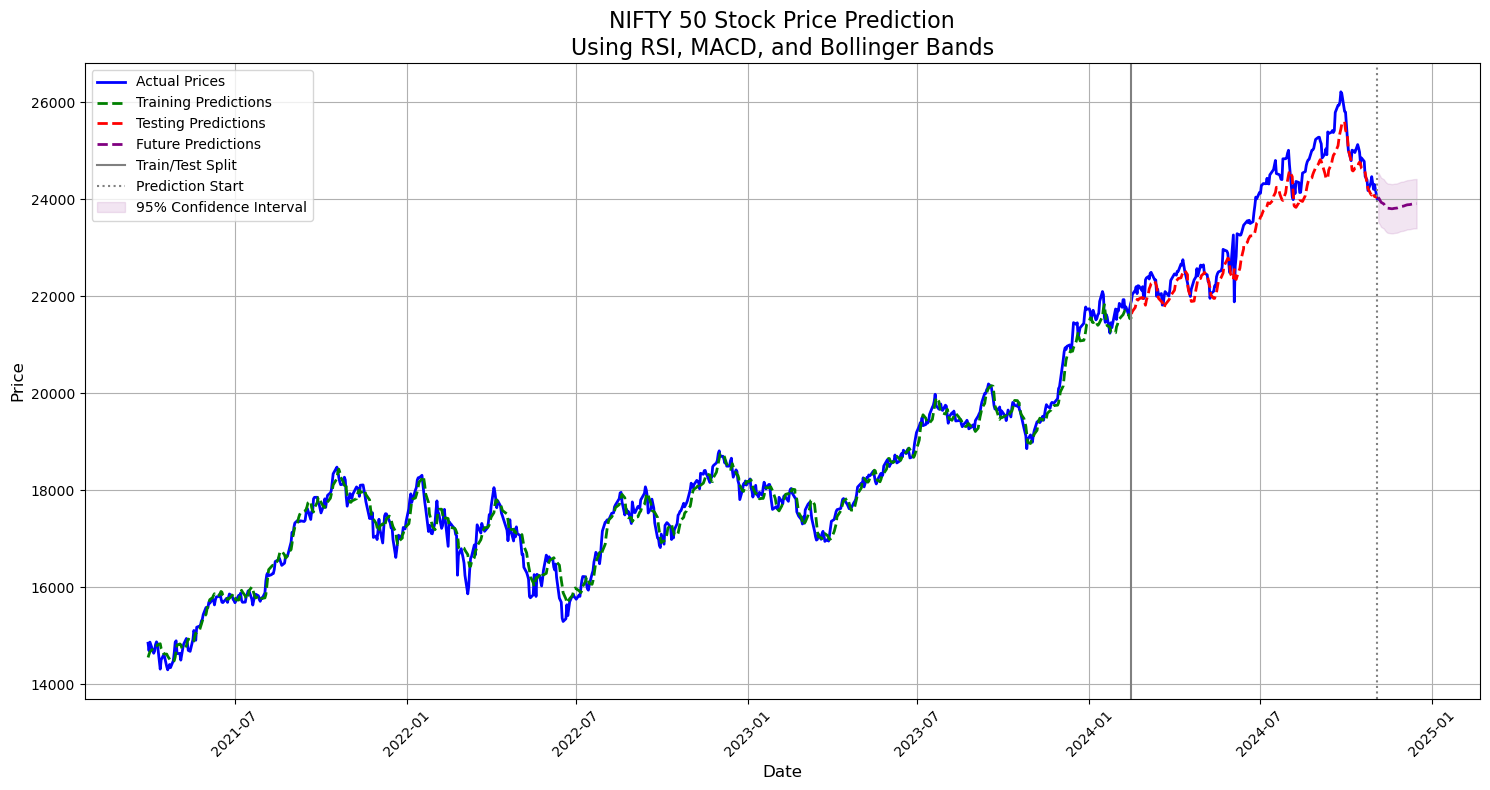


Performance Metrics:
Root Mean Squared Error: 401.73
Mean Absolute Error: 338.03

Future Price Predictions:
2024-11-05: 24039.47
2024-11-06: 24010.77
2024-11-07: 23975.69
2024-11-08: 23938.96
2024-11-11: 23904.25
2024-11-12: 23873.92
2024-11-13: 23849.17
2024-11-14: 23830.33
2024-11-15: 23817.16
2024-11-18: 23809.11
2024-11-19: 23805.43
2024-11-20: 23805.34
2024-11-21: 23808.10
2024-11-22: 23812.98
2024-11-25: 23819.39
2024-11-26: 23826.79
2024-11-27: 23834.78
2024-11-28: 23842.99
2024-11-29: 23851.17
2024-12-02: 23859.11
2024-12-03: 23866.67
2024-12-04: 23873.74
2024-12-05: 23880.26
2024-12-06: 23886.21
2024-12-09: 23891.56
2024-12-10: 23896.34
2024-12-11: 23900.56
2024-12-12: 23904.24
2024-12-13: 23907.42
2024-12-16: 23910.14


In [13]:
import numpy as np
import pandas as pd
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def add_core_indicators(df):
    """
    Add only three core technical indicators:
    - RSI for momentum
    - MACD for trend
    - Bollinger Bands for volatility
    """
    # Create a focused strategy with just three indicators
    strategy = ta.Strategy(
        name="Core Technical Indicators",
        description="RSI, MACD, and Bollinger Bands",
        ta=[
            {"kind": "rsi", "length": 14},            # Momentum
            {"kind": "macd", "fast": 12, "slow": 26}, # Trend
            {"kind": "bbands", "length": 20}          # Volatility
        ]
    )
    
    # Calculate indicators
    df.ta.strategy(strategy)
    
    # Fill NaN values
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    return df

def prepare_stock_data(data_True):
    """
    Prepare stock data with only core technical indicators
    """
    # Convert date to datetime
    dates = pd.DatetimeIndex(pd.to_datetime(data_True['Date']))
    
    # Add technical indicators
    df_with_indicators = add_core_indicators(data_True)
    
    # Select only essential features
    feature_columns = [
        'Close',          # Price
        'RSI_14',        # Momentum
        'MACD_12_26_9',  # Trend
        'BBL_20_2.0',    # Lower Bollinger Band
        'BBM_20_2.0',    # Middle Bollinger Band
        'BBU_20_2.0'     # Upper Bollinger Band
    ]
    
    # Ensure all required columns exist
    existing_columns = [col for col in feature_columns if col in df_with_indicators.columns]
    
    print("Using indicators:", existing_columns)
    features = df_with_indicators[existing_columns].values
    
    return features, dates

def prepare_data(data, time_steps):
    """
    Prepare data for LSTM model
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:i+time_steps])
        y.append(scaled_data[i+time_steps, 0])  # Close price is first column
    
    return np.array(X), np.array(y), scaler

def create_model(time_steps, n_features):
    """
    Create simplified LSTM model
    """
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def generate_future_dates(last_date, num_days):
    """
    Generate future dates for predictions
    """
    future_dates = []
    current_date = pd.to_datetime(last_date)
    
    while len(future_dates) < num_days:
        current_date += timedelta(days=1)
        if current_date.weekday() < 5:  # Skip weekends
            future_dates.append(current_date)
    
    return pd.DatetimeIndex(future_dates)

def predict_future(model, last_sequence, scaler, n_future):
    """
    Predict future values - fixed array indexing to handle deprecation warnings
    """
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_future):
        # Predict next value
        current_prediction = model.predict(current_sequence.reshape(1, *current_sequence.shape))
        
        # Create dummy row for inverse transform
        dummy_row = np.zeros((1, scaler.scale_.shape[0]))
        # Fix: Extract single element from prediction array
        dummy_row[0, 0] = current_prediction.item()
        
        # Get actual price
        predicted_price = scaler.inverse_transform(dummy_row)[0, 0]
        future_predictions.append(predicted_price)
        
        # Update sequence
        new_row = current_sequence[-1].copy()
        # Fix: Extract single element from prediction array
        new_row[0] = current_prediction.item()
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = new_row
    
    return np.array(future_predictions).reshape(-1, 1)

def plot_predictions_with_future(dates, actual_values, train_predictions, test_predictions, 
                               future_dates, future_predictions, train_size, time_steps, ticker):
    """
    Plot predictions with uncertainty bands
    """
    plt.figure(figsize=(15, 8))
    
    plot_dates = dates[time_steps:]
    
    # Plot actual values and predictions
    plt.plot(plot_dates, actual_values.flatten(), 
             label='Actual Prices', color='blue', linewidth=2)
    
    train_dates = plot_dates[:train_size]
    plt.plot(train_dates, train_predictions.flatten(), 
             label='Training Predictions', color='green', linestyle='--', linewidth=2)
    
    test_dates = plot_dates[train_size:]
    plt.plot(test_dates, test_predictions.flatten(), 
             label='Testing Predictions', color='red', linestyle='--', linewidth=2)
    
    plt.plot(future_dates, future_predictions.flatten(), 
             label='Future Predictions', color='purple', linestyle='--', linewidth=2)
    
    # Add split lines
    plt.axvline(x=plot_dates[train_size], color='gray', linestyle='-', 
                label='Train/Test Split')
    plt.axvline(x=plot_dates[-1], color='gray', linestyle=':', 
                label='Prediction Start')
    
    # Add confidence interval
    future_std = np.std(test_predictions - actual_values[train_size:])
    plt.fill_between(future_dates,
                    (future_predictions - future_std * 2).flatten(),
                    (future_predictions + future_std * 2).flatten(),
                    color='purple', alpha=0.1, label='95% Confidence Interval')
    
    plt.title(f'{ticker} Stock Price Prediction\nUsing RSI, MACD, and Bollinger Bands', 
              fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def predict_stock_prices(data_True, ticker="NIFTY 50", time_steps=60, train_split=0.8, future_days=30):
    """
    Main prediction function with focused indicators
    """
    # Prepare data
    features, dates = prepare_stock_data(data_True)
    X, y, scaler = prepare_data(features, time_steps)
    
    # Split data
    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Create and train model
    n_features = X.shape[2]
    model = create_model(time_steps, n_features)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                       validation_split=0.1, verbose=1)
    
    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # Predict future values
    last_sequence = X[-1]
    future_predictions = predict_future(model, last_sequence, scaler, future_days)
    
    # Generate future dates
    future_dates = generate_future_dates(dates[-1], future_days)
    
    # Prepare for inverse transformation
    dummy_train = np.zeros((len(train_predictions), scaler.scale_.shape[0]))
    dummy_train[:, 0] = train_predictions.flatten()
    dummy_test = np.zeros((len(test_predictions), scaler.scale_.shape[0]))
    dummy_test[:, 0] = test_predictions.flatten()
    dummy_actual = np.zeros((len(y), scaler.scale_.shape[0]))
    dummy_actual[:, 0] = y
    
    # Inverse transform
    train_predictions = scaler.inverse_transform(dummy_train)[:, 0].reshape(-1, 1)
    test_predictions = scaler.inverse_transform(dummy_test)[:, 0].reshape(-1, 1)
    actual_values = scaler.inverse_transform(dummy_actual)[:, 0].reshape(-1, 1)
    
    # Plot results
    plot_predictions_with_future(dates, actual_values, train_predictions, test_predictions,
                               future_dates, future_predictions, train_size, time_steps, ticker)
    
    # Calculate error metrics
    mse = np.mean((test_predictions - actual_values[train_size:]) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(test_predictions - actual_values[train_size:]))
    
    print("\nPerformance Metrics:")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    
    print("\nFuture Price Predictions:")
    for date, price in zip(future_dates, future_predictions):
        print(f"{date.strftime('%Y-%m-%d')}: {price[0]:.2f}")
    
    return {
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'future_predictions': future_predictions,
        'actual_values': actual_values,
        'dates': dates[time_steps:],
        'future_dates': future_dates,
        'model': model,
        'scaler': scaler,
        'history': history
    }

# Example usage
if __name__ == "__main__":
    # Get your historical data
    data = historical_data('NIFTY 50', "2021-01-01 09:15:00", "2024-11-05 15:30:00", "day")
    
    # Prepare the data
    data_True = pd.DataFrame(data)
    data_True.rename(columns={
        'date': 'Date', 
        'open': 'Open', 
        'high': 'High', 
        'low': 'Low', 
        'close': 'Close', 
        'volume': 'Volume'
    }, inplace=True)
    
    # Clean the data
    data_True.dropna(inplace=True)
    data_True.reset_index(drop=True, inplace=True)
    data_True['Date'] = pd.to_datetime(data_True['Date'])
    
    # Predict stock prices
    results = predict_stock_prices(
        data_True,
        ticker="NIFTY 50",
        time_steps=60,
        train_split=0.8,
        future_days=30
    )

In [ ]:
#yfinance version

[*********************100%%**********************]  1 of 1 completed


Using indicators: ['Close', 'RSI_14', 'MACD_12_26_9', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0']
Epoch 1/50


C:\Users\Kishan\AppData\Local\Temp\ipykernel_8208\1160729973.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
C:\Users\Kishan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - loss: 0.0395 - val_loss: 0.0332
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0024 - val_loss: 5.6990e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0024 - val_loss: 6.6133e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0016 - val_loss: 5.2619e-04
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0019 - val_loss: 7.1394e-04
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015 - val_loss: 8.3516e-04
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step 

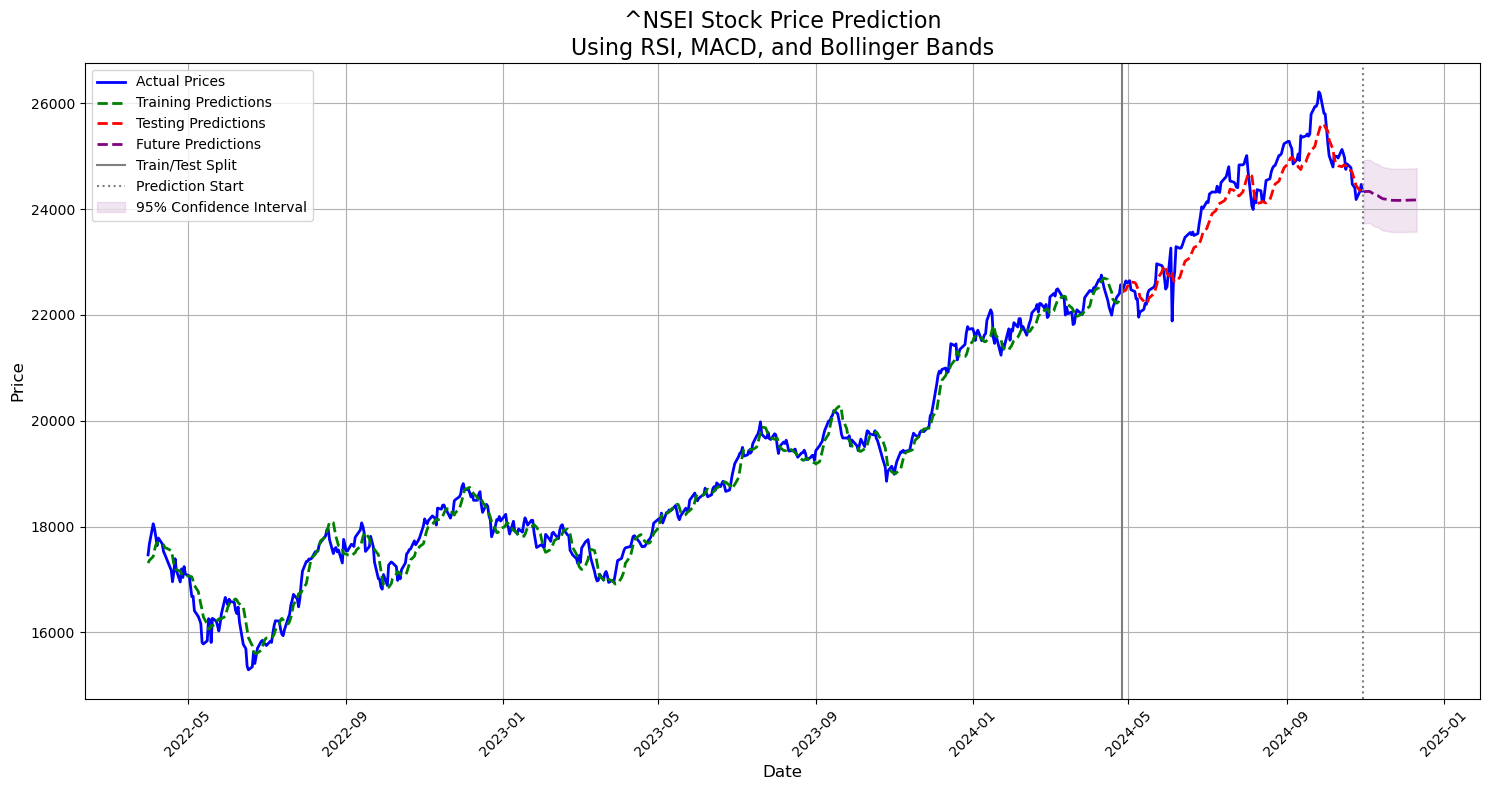


Performance Metrics:
Root Mean Squared Error: 363.86
Mean Absolute Error: 308.56

Future Price Predictions:
2024-10-31: 24321.61
2024-11-01: 24332.68
2024-11-04: 24334.73
2024-11-05: 24327.22
2024-11-06: 24312.64
2024-11-07: 24293.99
2024-11-08: 24273.79
2024-11-11: 24253.88
2024-11-12: 24235.46
2024-11-13: 24219.20
2024-11-14: 24205.36
2024-11-15: 24193.97
2024-11-18: 24184.89
2024-11-19: 24177.87
2024-11-20: 24172.65
2024-11-21: 24168.95
2024-11-22: 24166.48
2024-11-25: 24165.01
2024-11-26: 24164.32
2024-11-27: 24164.22
2024-11-28: 24164.55
2024-11-29: 24165.18
2024-12-02: 24166.03
2024-12-03: 24166.99
2024-12-04: 24168.02
2024-12-05: 24169.07
2024-12-06: 24170.10
2024-12-09: 24171.10
2024-12-10: 24172.05
2024-12-11: 24172.94


In [11]:
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import timedelta
symbol = "^NSEI"
def add_core_indicators(df):
    """
    Add only three core technical indicators:
    - RSI for momentum
    - MACD for trend
    - Bollinger Bands for volatility
    """
    strategy = ta.Strategy(
        name="Core Technical Indicators",
        description="RSI, MACD, and Bollinger Bands",
        ta=[
            {"kind": "rsi", "length": 14},
            {"kind": "macd", "fast": 12, "slow": 26},
            {"kind": "bbands", "length": 20}
        ]
    )
    df.ta.strategy(strategy)
    df = df.fillna(method='ffill').fillna(method='bfill')
    return df

def prepare_stock_data(data_True):
    dates = pd.DatetimeIndex(pd.to_datetime(data_True['Date']))
    df_with_indicators = add_core_indicators(data_True)
    feature_columns = [
        'Close',
        'RSI_14',
        'MACD_12_26_9',
        'BBL_20_2.0',
        'BBM_20_2.0',
        'BBU_20_2.0'
    ]
    existing_columns = [col for col in feature_columns if col in df_with_indicators.columns]
    print("Using indicators:", existing_columns)
    features = df_with_indicators[existing_columns].values
    return features, dates

def prepare_data(data, time_steps):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:i + time_steps])
        y.append(scaled_data[i + time_steps, 0])
    return np.array(X), np.array(y), scaler

def create_model(time_steps, n_features):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def generate_future_dates(last_date, num_days):
    future_dates = []
    current_date = pd.to_datetime(last_date)
    while len(future_dates) < num_days:
        current_date += timedelta(days=1)
        if current_date.weekday() < 5:
            future_dates.append(current_date)
    return pd.DatetimeIndex(future_dates)

def predict_future(model, last_sequence, scaler, n_future):
    future_predictions = []
    current_sequence = last_sequence.copy()
    for _ in range(n_future):
        current_prediction = model.predict(current_sequence.reshape(1, *current_sequence.shape))
        dummy_row = np.zeros((1, scaler.scale_.shape[0]))
        dummy_row[0, 0] = current_prediction.item()
        predicted_price = scaler.inverse_transform(dummy_row)[0, 0]
        future_predictions.append(predicted_price)
        new_row = current_sequence[-1].copy()
        new_row[0] = current_prediction.item()
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = new_row
    return np.array(future_predictions).reshape(-1, 1)

def plot_predictions_with_future(dates, actual_values, train_predictions, test_predictions, 
                                 future_dates, future_predictions, train_size, time_steps, ticker):
    plt.figure(figsize=(15, 8))
    plot_dates = dates[time_steps:]
    plt.plot(plot_dates, actual_values.flatten(), label='Actual Prices', color='blue', linewidth=2)
    train_dates = plot_dates[:train_size]
    plt.plot(train_dates, train_predictions.flatten(), label='Training Predictions', color='green', linestyle='--', linewidth=2)
    test_dates = plot_dates[train_size:]
    plt.plot(test_dates, test_predictions.flatten(), label='Testing Predictions', color='red', linestyle='--', linewidth=2)
    plt.plot(future_dates, future_predictions.flatten(), label='Future Predictions', color='purple', linestyle='--', linewidth=2)
    plt.axvline(x=plot_dates[train_size], color='gray', linestyle='-', label='Train/Test Split')
    plt.axvline(x=plot_dates[-1], color='gray', linestyle=':', label='Prediction Start')
    future_std = np.std(test_predictions - actual_values[train_size:])
    plt.fill_between(future_dates,
                     (future_predictions - future_std * 2).flatten(),
                     (future_predictions + future_std * 2).flatten(),
                     color='purple', alpha=0.1, label='95% Confidence Interval')
    plt.title(f'{ticker} Stock Price Prediction\nUsing RSI, MACD, and Bollinger Bands', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def predict_stock_prices(data_True, ticker=symbol, time_steps=60, train_split=0.8, future_days=30):
    features, dates = prepare_stock_data(data_True)
    X, y, scaler = prepare_data(features, time_steps)
    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    n_features = X.shape[2]
    model = create_model(time_steps, n_features)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    last_sequence = X[-1]
    future_predictions = predict_future(model, last_sequence, scaler, future_days)
    future_dates = generate_future_dates(dates[-1], future_days)
    dummy_train = np.zeros((len(train_predictions), scaler.scale_.shape[0]))
    dummy_train[:, 0] = train_predictions.flatten()
    dummy_test = np.zeros((len(test_predictions), scaler.scale_.shape[0]))
    dummy_test[:, 0] = test_predictions.flatten()
    dummy_actual = np.zeros((len(y), scaler.scale_.shape[0]))
    dummy_actual[:, 0] = y
    train_predictions = scaler.inverse_transform(dummy_train)[:, 0].reshape(-1, 1)
    test_predictions = scaler.inverse_transform(dummy_test)[:, 0].reshape(-1, 1)
    actual_values = scaler.inverse_transform(dummy_actual)[:, 0].reshape(-1, 1)
    plot_predictions_with_future(dates, actual_values, train_predictions, test_predictions,
                                 future_dates, future_predictions, train_size, time_steps, ticker)
    mse = np.mean((test_predictions - actual_values[train_size:]) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(test_predictions - actual_values[train_size:]))
    print("\nPerformance Metrics:")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print("\nFuture Price Predictions:")
    for date, price in zip(future_dates, future_predictions):
        print(f"{date.strftime('%Y-%m-%d')}: {price[0]:.2f}")
    return {
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'future_predictions': future_predictions,
        'actual_values': actual_values,
        'dates': dates[time_steps:],
        'future_dates': future_dates,
        'model': model,
        'scaler': scaler,
        'history': history
    }

# Example usage
if __name__ == "__main__":
    ticker_symbol = symbol
    start_date = "2022-01-01"
    end_date = "2024-10-31"
    data = yf.download(ticker_symbol, start=start_date, end=end_date, interval="1d")
    data.reset_index(inplace=True)
    data.rename(columns={
        'Date': 'Date', 
        'Open': 'Open', 
        'High': 'High', 
        'Low': 'Low', 
        'Close': 'Close', 
        'Volume': 'Volume'
    }, inplace=True)
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    results = predict_stock_prices(
        data,
        ticker=symbol,
        time_steps=60,
        train_split=0.8,
        future_days=30
    )


In [ ]:
streamlit part 

In [18]:
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from datetime import timedelta
import matplotlib.pyplot as plt

st.set_option('deprecation.showPyplotGlobalUse', False)

def add_core_indicators(df):
    strategy = ta.Strategy(
        name="Core Technical Indicators",
        description="RSI, MACD, and Bollinger Bands",
        ta=[
            {"kind": "rsi", "length": 14},
            {"kind": "macd", "fast": 12, "slow": 26},
            {"kind": "bbands", "length": 20}
        ]
    )
    df.ta.strategy(strategy)
    df = df.fillna(method='ffill').fillna(method='bfill')
    return df

def prepare_stock_data(data_True):
    dates = pd.DatetimeIndex(pd.to_datetime(data_True.index))
    df_with_indicators = add_core_indicators(data_True)
    feature_columns = ['Close', 'RSI_14', 'MACD_12_26_9', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0']
    features = df_with_indicators[feature_columns].values
    return features, dates

def prepare_data(data, time_steps):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:i + time_steps])
        y.append(scaled_data[i + time_steps, 0])
    return np.array(X), np.array(y), scaler

def create_model(time_steps, n_features):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def predict_future(model, last_sequence, scaler, n_future):
    future_predictions = []
    current_sequence = last_sequence.copy()
    for _ in range(n_future):
        current_prediction = model.predict(current_sequence.reshape(1, *current_sequence.shape))
        dummy_row = np.zeros((1, scaler.scale_.shape[0]))
        dummy_row[0, 0] = current_prediction.item()
        predicted_price = scaler.inverse_transform(dummy_row)[0, 0]
        future_predictions.append(predicted_price)
        new_row = current_sequence[-1].copy()
        new_row[0] = current_prediction.item()
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = new_row
    return np.array(future_predictions).reshape(-1, 1)

def plot_predictions_with_future(dates, actual_values, train_predictions, test_predictions, 
                                 future_dates, future_predictions, train_size, time_steps, ticker):
    plt.figure(figsize=(12, 6))
    plot_dates = dates[time_steps:]
    plt.plot(plot_dates, actual_values.flatten(), label='Actual Prices', color='blue', linewidth=2)
    train_dates = plot_dates[:train_size]
    plt.plot(train_dates, train_predictions.flatten(), label='Training Predictions', color='green', linestyle='--', linewidth=2)
    test_dates = plot_dates[train_size:]
    plt.plot(test_dates, test_predictions.flatten(), label='Testing Predictions', color='red', linestyle='--', linewidth=2)
    plt.plot(future_dates, future_predictions.flatten(), label='Future Predictions', color='purple', linestyle='--', linewidth=2)
    plt.axvline(x=plot_dates[train_size], color='gray', linestyle='-', label='Train/Test Split')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    st.pyplot()

st.title("Stock Price Prediction with Technical Indicators")

ticker = st.text_input("Enter Stock Ticker Symbol (e.g., AAPL, MSFT):", value="AAPL")
start_date = st.date_input("Start Date", pd.to_datetime("2021-01-01"))
end_date = st.date_input("End Date", pd.to_datetime("2024-10-31"))
future_days = st.slider("Select number of future days to predict:", 1, 60, value=30)

if st.button("Predict"):
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    if not data.empty:
        data.reset_index(inplace=True)
        features, dates = prepare_stock_data(data)
        X, y, scaler = prepare_data(features, 60)
        
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        n_features = X.shape[2]

        model = create_model(60, n_features)
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)
        last_sequence = X[-1]
        future_predictions = predict_future(model, last_sequence, scaler, future_days)

        future_dates = pd.date_range(dates[-1] + timedelta(days=1), periods=future_days, freq='B')
        
        dummy_train = np.zeros((len(train_predictions), scaler.scale_.shape[0]))
        dummy_train[:, 0] = train_predictions.flatten()
        dummy_test = np.zeros((len(test_predictions), scaler.scale_.shape[0]))
        dummy_test[:, 0] = test_predictions.flatten()
        dummy_actual = np.zeros((len(y), scaler.scale_.shape[0]))
        dummy_actual[:, 0] = y

        train_predictions = scaler.inverse_transform(dummy_train)[:, 0].reshape(-1, 1)
        test_predictions = scaler.inverse_transform(dummy_test)[:, 0].reshape(-1, 1)
        actual_values = scaler.inverse_transform(dummy_actual)[:, 0].reshape(-1, 1)
        
        plot_predictions_with_future(dates, actual_values, train_predictions, test_predictions,
                                     future_dates, future_predictions, train_size, 60, ticker)
        
        st.write("Future Price Predictions:")
        for date, price in zip(future_dates, future_predictions):
            st.write(f"{date.strftime('%Y-%m-%d')}: {price[0]:.2f}")
    else:
        st.error("No data found for this ticker and date range.")
